### Locally Linear Embedding (LLE) tutorial

0. Load Packages

In [33]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial import distance_matrix
from matplotlib import offsetbox
from sklearn.preprocessing import MinMaxScaler
from utils import visualize_mnist
import time
import matplotlib.patheffects as PathEffects

import warnings, random
warnings.filterwarnings('ignore')

random.seed(1)
np.random.seed(1)

1. load MNIST dataset

In [20]:
N = 500 # number of samples
K = 20 # number of neighbors

# load dataset using keras
(x_train,y_train),(x_test,y_test) = mnist.load_data()

# concat train & test dataset
full_imgs = np.concatenate((x_train,x_test), axis=0)
full_y = np.concatenate((y_train,y_test))

# randomly select 500 samples
sampling_idx = np.random.randint(0,full_imgs.shape[0], size=(N,))
imgs, labels = full_imgs[sampling_idx], full_y[sampling_idx]

# flatten images to 1d vector
X = imgs.reshape(N, -1)

print(f'img shape : {imgs.shape} | X shape : {X.shape} | labels shape : {labels.shape}')

img shape : (500, 28, 28) | X shape : (500, 784) | labels shape : (500,)


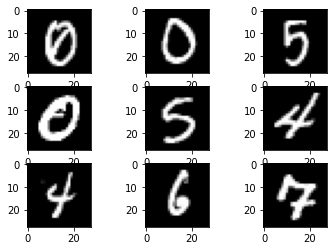

In [21]:
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(imgs[i], cmap=plt.get_cmap('gray'))

2. LLE STEP 1 - Define neighbors for all $x_i$ where $i = 1 , ... , N$

In [22]:
def get_neighbors(x, emb_dim:int = 2, K:int = 10):
    """ x : data, shape = (N, D), where D is original data dimensions
        emb_dim : embedding dimensions
        K : k-neighbors, user defined parameter(hyperparameter)
    """
    # number of samples and data dimensions
    N, D = x.shape
    
    # get euclidean distance matrix to fine neighbors
    distance_M = distance_matrix(x,x)
    
    # get K-neigbors for each x
    indices = distance_M.argsort(axis=1)
    neighbors = indices[:,1:K+1]
    
    return neighbors

In [23]:
neighbors = get_neighbors(X, K=K)
print(f'neighbor indices matrix shape : (N, K) = {neighbors.shape}')

neighbor indices matrix shape : (N, K) = (500, 20)


3. LLE STEP 2 - Find $w_{ij}$ that minimize ${|x_i-\sum_{j=1}^K w_{ij}*x_j|}^2$ for all $x_i$

In [24]:
def get_W(x, emb_dim:int = 2, K:int = 10, neighbors:np.array = None):
    """ x : data, shape = (N, D), where D is original data dimensions
        emb_dim : embedding dimensions
        K : k-neighbors, user defined parameter(hyperparameter)
        neighbors : k-neighbors indices matrix
    """
    # number of samples and data dimensions
    N, D = x.shape
    
    # W_i shape : N,K
    W_i = np.zeros_like(neighbors, dtype=float)
    
    for i in range(N):
        x_j = x[neighbors[i,:],:] # neighbors of x_i
        
        diff = x_j - np.repeat(np.expand_dims(x[0,:],0), K, axis=0) # x_i - x_j for all j
        mse = np.dot(diff, np.transpose(diff))
        mse = mse+np.identity(K) + 1e-3*np.trace(mse)
        W_i[i,:] = np.linalg.solve(mse, np.ones((K,1)))[:,0] # get w_ij
        W_i[i,:] = W_i[i,:] / np.sum(W_i[i,:]) # constraints sum of w_j = 1
    
    # W shape : N,N
    W = np.zeros(shape=(N,N), dtype=float)
    
    for i in range(N):
        j_indices = neighbors[i]
        for k,j in enumerate(j_indices):
            W[i,j] = W_i[i,k]
    
    return W

In [25]:
W = get_W(X, K=K, neighbors=neighbors)
print(f'W matrix shape : (N, N) = {W.shape}')

W matrix shape : (N, N) = (500, 500)


4. LLE STEP 3 - Fine $y_i$ that minimize ${|y_i-\sum_{j=1}^K w_{ij}*y_j|}^2 = y^TMy$ for all $y_i$

In [26]:
def get_y(x, emb_dim:int = 2, K:int = 10, neighbors:np.array = None, W:np.array = None):
    """ x : data, shape = (N, D), where D is original data dimensions
        emb_dim : embedding dimensions
        K : k-neighbors, user defined parameter(hyperparameter)
        neighbors : k-neighbors indices matrix, shape : (N, K)
        W : W matrix, shape : (N, N)
    """
    N, D = x.shape
    
    I = np.identity(N, dtype=float) # I shape : (N,N)
    M = np.matmul(np.transpose(I-W),(I-W)) # M shape : (N,N)

    ei_vals, ei_vec = np.linalg.eig(M)
    indices = np.argsort(ei_vals)
    emb_idx = indices[1:emb_dim+1]
    
    y = ei_vec[:,emb_idx]*np.sqrt(N)
    
    return y

In [27]:
y = get_y(X, K=K, neighbors=neighbors, W=W)

5. Visualization

(<Figure size 864x864 with 1 Axes>,
 <AxesSubplot:title={'center':'LLE results of MNIST'}>,
 [Text(0.1595740163530571, -0.1569167311836278, '0'),
  Text(-0.027427724434077053, 0.035816087509318736, '1'),
  Text(-0.016733321603060628, 0.018248626701041708, '2'),
  Text(-0.000612409191094317, -0.10228418885344705, '3'),
  Text(-0.11701032028257133, 0.06976034580297981, '4'),
  Text(0.10497868545790726, -0.07840699452562272, '5'),
  Text(0.028545538998744825, 0.09043068269207784, '6'),
  Text(0.08078363236383, 0.054199751580878044, '7'),
  Text(-0.05848615817249676, -0.010651916759532429, '8'),
  Text(0.11643818333812757, 0.14978062558872385, '9')])

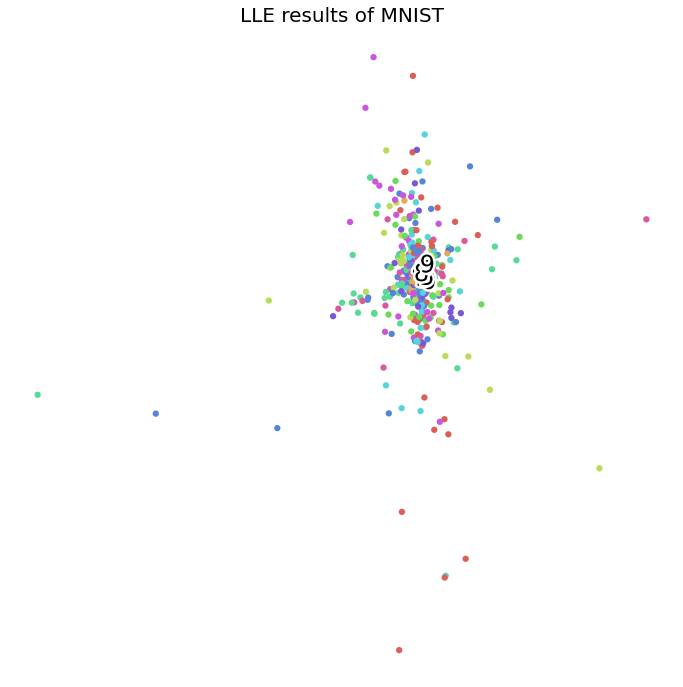

In [30]:
title = 'LLE results of MNIST'
visualize_mnist(y, labels, title)

6. Compared with sklearn package

In [16]:
from sklearn.manifold import LocallyLinearEmbedding

LLE = LocallyLinearEmbedding(eigen_solver='auto', n_components=2, n_neighbors=K, random_state=0)

X_reduced = LLE.fit_transform(X)

(<Figure size 864x864 with 1 Axes>,
 <AxesSubplot:title={'center':'LLE results of MNIST with sklearn'}>,
 [Text(0.012769284706807663, -0.004354991161957619, '0'),
  Text(-0.07362007901373822, -0.051545990537208236, '1'),
  Text(-0.0020347667765671542, 0.013935499668160519, '2'),
  Text(-0.0008066311192589231, -0.007359770050734392, '3'),
  Text(0.02525618332423642, 0.008181229784709037, '4'),
  Text(-0.0007624180140356126, -0.0002820668051238283, '5'),
  Text(0.0033961538160599, -0.009277056754762193, '6'),
  Text(0.039107010304574474, 0.017380973800923887, '7'),
  Text(-0.00684362661199607, 0.011891056152660995, '8'),
  Text(0.03511741334002137, 0.003063112482594648, '9')])

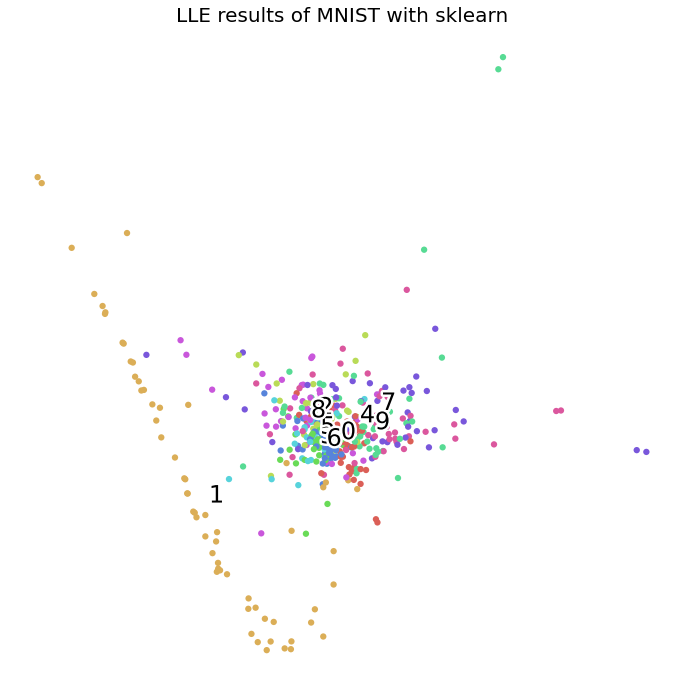

In [31]:
title = 'LLE results of MNIST with sklearn'
visualize_mnist(X_reduced, labels, title)

sklearn을 쓰는게 좋음, from scratch code 어딘가 오류가 있는듯

### K에 따른 LLE 변화

k를 5~50까지 5 단위로 변화시키며 관찰

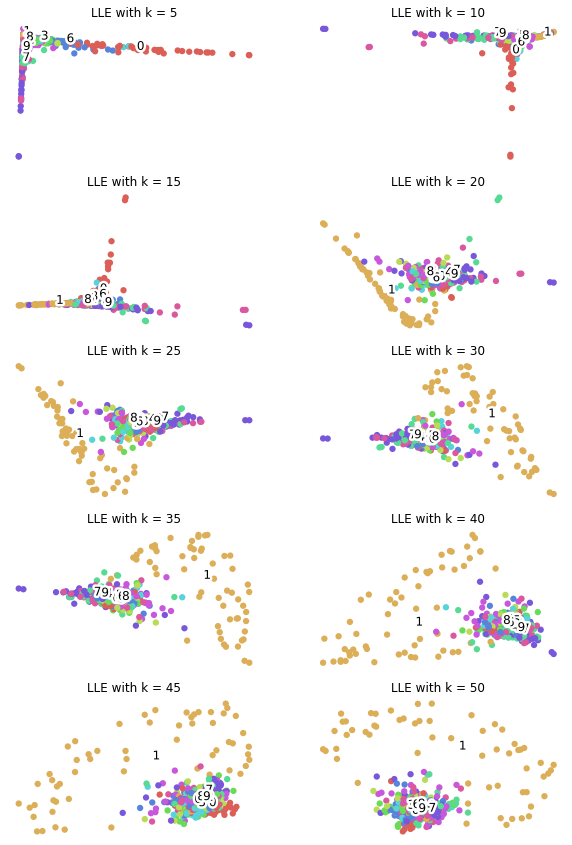

In [35]:
k_list = range(5,51,5)

plt.figure(figsize=(10,15))
for i, k in enumerate(k_list):
    s_time = time.time()
    lle = LocallyLinearEmbedding(n_neighbors=k, n_components=2, random_state=0)
    X_reduced = lle.fit_transform(X)
    required_time = time.time()-s_time
    
    title = f'LLE with k = {k}'
    
    plt.subplot(5,2,i+1)
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("hls", num_classes))
    
    plt.scatter(X_reduced[:,0], X_reduced[:,1], lw=0, s=40, c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    plt.title(title)
    plt.axis('off')
    plt.axis('tight')
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(X_reduced[labels == i, :], axis=0)
        txt = plt.text(xtext, ytext, str(i), fontsize=12)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

k가 커질수록 $x_j$들을 통해서 $x_i$를 더 잘 설명할 수 있기 때문에 loss는 낮아짐

하지만, k가 커질수록 local한 지역에서의 선형성이 사라지기 때문에 결국 좋지 못한 성능을 보여줌